<a href="https://colab.research.google.com/github/Moavia-Hassan/Bone_Crack_Detection/blob/main/Bone_fracture_detection_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install pycocotools pandas
# !pip install tensorflow
# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from PIL import Image
import os
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set dataset path (adjust this to your dataset location)
dataset_path = '/content/drive/MyDrive/FracAtlas'  # Update this path
csv_path = os.path.join(dataset_path, 'dataset.csv')
coco = COCO(os.path.join(dataset_path, 'Annotations/COCO JSON', 'COCO_fracture_masks.json'))
df = pd.read_csv(csv_path)
print(df.head())

loading annotations into memory...
Done (t=2.93s)
creating index...
index created!
         image_id  hand  leg  hip  shoulder  mixed  hardware  multiscan  \
0  IMG0000000.jpg     0    1    0         0      0         0          1   
1  IMG0000001.jpg     0    1    0         0      0         0          1   
2  IMG0000002.jpg     0    1    0         0      0         0          1   
3  IMG0000003.jpg     0    1    0         0      0         0          1   
4  IMG0000004.jpg     0    1    0         0      0         0          1   

   fractured  fracture_count  frontal  lateral  oblique  
0          0               0        1        1        0  
1          0               0        1        1        0  
2          0               0        1        1        0  
3          0               0        0        1        1  
4          0               0        0        1        1  


In [ ]:
# Create mapping from CSV image_id to COCO id
base_name_to_id = {}
for img_info in coco.loadImgs(coco.getImgIds()):
    file_name = img_info['file_name']
    base_name = os.path.basename(file_name).split('.')[0]
    base_name_to_id[base_name] = img_info['id']
df['coco_id'] = df['image_id'].map(base_name_to_id)
print(f"Number of missing mappings: {df['coco_id'].isna().sum()}")

Number of missing mappings: 4083


In [ ]:
# Cell 4: Fix Mapping with Case Insensitivity
# Step 1: Build COCO mapping from file_name to id
base_name_to_id = {}
coco_images = coco.loadImgs(coco.getImgIds())
print(f"Total images in COCO JSON: {len(coco_images)}")

for img_info in coco_images:
    file_name = img_info['file_name']
    base_name = os.path.basename(file_name).split('.')[0].lower()  # Remove extension, lowercase
    base_name_to_id[base_name] = img_info['id']
    if len(base_name_to_id) <= 5:
        print(f"COCO file_name: {file_name}, Extracted base_name: {base_name}, COCO ID: {img_info['id']}")

# Step 2: Clean CSV image_id and map to COCO id
df['image_id_clean'] = df['image_id'].str.replace('.jpg', '', case=False).str.lower()
df['coco_id'] = df['image_id_clean'].map(base_name_to_id)

# Debug: Print sample mappings (both NaN and non-NaN)
print("\nSample CSV image_ids (cleaned) and their coco_ids (first 10 rows):")
print(df[['image_id_clean', 'coco_id']].head(20).to_string(index=False))
print("\nSample CSV image_ids with valid coco_ids (first 5 non-NaN rows):")
print(df[df['coco_id'].notna()][['image_id_clean', 'coco_id']].head(5).to_string(index=False))

# Step 3: Check for missing mappings
missing_count = df['coco_id'].isna().sum()
print(f"\nNumber of missing mappings: {missing_count}")

# Debug mismatches
if missing_count > 0:
    missing_ids = df[df['coco_id'].isna()]['image_id_clean'].head().tolist()
    print(f"Sample of unmatched CSV image_ids: {missing_ids}")
    print("\nAll COCO base names (first 10):")
    print(list(base_name_to_id.keys())[:10])

Total images in COCO JSON: 717
COCO file_name: IMG0000019.jpg, Extracted base_name: img0000019, COCO ID: 1
COCO file_name: IMG0000025.jpg, Extracted base_name: img0000025, COCO ID: 2
COCO file_name: IMG0000044.jpg, Extracted base_name: img0000044, COCO ID: 3
COCO file_name: IMG0000057.jpg, Extracted base_name: img0000057, COCO ID: 4
COCO file_name: IMG0000058.jpg, Extracted base_name: img0000058, COCO ID: 5

Sample CSV image_ids (cleaned) and their coco_ids (first 10 rows):
image_id_clean  coco_id
    img0000000      NaN
    img0000001      NaN
    img0000002      NaN
    img0000003      NaN
    img0000004      NaN
    img0000005      NaN
    img0000006      NaN
    img0000007      NaN
    img0000008      NaN
    img0000009      NaN
    img0000010      NaN
    img0000011      NaN
    img0000012      NaN
    img0000013      NaN
    img0000014      NaN
    img0000015      NaN
    img0000016      NaN
    img0000017      NaN
    img0000018      NaN
    img0000019      1.0

Sample CSV image

In [ ]:
# Cell 5: Filter out missing mappings and perform stratified split
# Filter rows with valid coco_id
df_filtered = df.dropna(subset=['coco_id']).copy()  # Create a copy to avoid SettingWithCopyWarning
print(f"Filtered dataset size: {len(df_filtered)}")

# Ensure coco_id is integer
df_filtered['coco_id'] = df_filtered['coco_id'].astype(int)

# Validate coco_id against COCO JSON
valid_coco_ids = set(coco.getImgIds())
df_filtered = df_filtered[df_filtered['coco_id'].isin(valid_coco_ids)]
print(f"Filtered dataset size after validation: {len(df_filtered)}")

# Check if filtered DataFrame is empty
if len(df_filtered) == 0:
    raise ValueError("Filtered dataset is empty after validation. Check the mapping between CSV and COCO JSON.")

# Stratified split based on 'fractured'
train_df, temp_df = train_test_split(df_filtered, test_size=0.3, stratify=df_filtered['fractured'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['fractured'], random_state=42)

# Extract IDs for dataset creation
train_ids = train_df['coco_id'].tolist()
val_ids = val_df['coco_id'].tolist()
test_ids = test_df['coco_id'].tolist()

# Validate IDs (ensure type consistency)
valid_coco_ids = set(coco.getImgIds())
invalid_train_ids = [id_ for id_ in train_ids if id_ not in valid_coco_ids]
invalid_val_ids = [id_ for id_ in val_ids if id_ not in valid_coco_ids]
invalid_test_ids = [id_ for id_ in test_ids if id_ not in valid_coco_ids]

# Debug: Print sample IDs and validation results
print(f"\nSample train_ids (first 5): {train_ids[:5]}")
print(f"Sample val_ids (first 5): {val_ids[:5]}")
print(f"Sample test_ids (first 5): {test_ids[:5]}")
print(f"\nInvalid train_ids: {len(invalid_train_ids)}")
print(f"Invalid val_ids: {len(invalid_val_ids)}")
print(f"Invalid test_ids: {len(invalid_test_ids)}")

# Verify the split
print(f"\nTrain set size: {len(train_ids)}, Fractured proportion: {train_df['fractured'].mean():.2f}")
print(f"Val set size: {len(val_ids)}, Fractured proportion: {val_df['fractured'].mean():.2f}")
print(f"Test set size: {len(test_ids)}, Fractured proportion: {test_df['fractured'].mean():.2f}")

Filtered dataset size: 717
Filtered dataset size after validation: 717

Sample train_ids (first 5): [196, 353, 659, 394, 423]
Sample val_ids (first 5): [348, 252, 585, 352, 187]
Sample test_ids (first 5): [605, 72, 554, 424, 464]

Invalid train_ids: 0
Invalid val_ids: 0
Invalid test_ids: 0

Train set size: 501, Fractured proportion: 1.00
Val set size: 108, Fractured proportion: 1.00
Test set size: 108, Fractured proportion: 1.00


In [ ]:
# Cell 6: Define Data Loading Function
# Purpose: Load images and their segmentation masks from the dataset.
def load_image_mask(image_id):
    # Debug: Print the type and value of image_id
    print(f"load_image_mask received image_id: {image_id}, type: {type(image_id)}")
    # Ensure image_id is an integer
    image_id = int(image_id)
    img_info = coco.loadImgs(image_id)[0]
    # Since all images in COCO are fractured, assume they are in images/fractured/
    folder = 'images/Fractured'
    file_name = img_info['file_name']
    image_path = os.path.join(dataset_path, folder, file_name)
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        raise e
    image = image.resize((256, 256))
    image = np.array(image) / 255.0
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((256, 256), dtype=np.uint8)
    for ann in anns:
        if 'segmentation' in ann:
            original_mask = coco.annToMask(ann)
            original_mask_pil = Image.fromarray(original_mask)
            resized_mask = original_mask_pil.resize((256, 256), Image.NEAREST)
            mask = np.maximum(mask, np.array(resized_mask))
    return image.astype(np.float32), mask.astype(np.float32)

def tf_load_data(image_id):
    # Debug: Print the type and value of image_id
    print(f"tf_load_data received image_id: {image_id}, type: {type(image_id)}")
    image_id = tf.squeeze(image_id)
    # Ensure image_id is an integer tensor
    image_id = tf.cast(image_id, tf.int32)
    image, mask = tf.py_function(load_image_mask, [image_id], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256])
    # Change the key to match the model's input layer name ('input_layer_4')
    return {'input_layer_2': image}, mask

In [ ]:
# Debug Cell: Test Data Loading
# Test load_image_mask on a few images
for test_id in train_ids[:3]:
    try:
        image, mask = load_image_mask(test_id)
        print(f"Image ID {test_id}: Image shape {image.shape}, Mask shape {mask.shape}, Mask sum {mask.sum()}")
    except Exception as e:
        print(f"Error with Image ID {test_id}: {e}")

# Test tf_load_data with a single image
test_dataset_single = tf.data.Dataset.from_tensor_slices([train_ids[0]]).map(tf_load_data)
for image_dict, mask in test_dataset_single:
    image = image_dict['input_layer_2']  # Extract the image tensor from the dictionary
    print(f"tf_load_data: Image shape {image.shape}, Mask shape {mask.shape}")

load_image_mask received image_id: 196, type: <class 'int'>
Image ID 196: Image shape (256, 256, 3), Mask shape (256, 256), Mask sum 791.0
load_image_mask received image_id: 353, type: <class 'int'>
Image ID 353: Image shape (256, 256, 3), Mask shape (256, 256), Mask sum 63.0
load_image_mask received image_id: 659, type: <class 'int'>
Image ID 659: Image shape (256, 256, 3), Mask shape (256, 256), Mask sum 100.0
tf_load_data received image_id: Tensor("args_0:0", shape=(), dtype=int32), type: <class 'tensorflow.python.framework.ops.SymbolicTensor'>
load_image_mask received image_id: 196, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
tf_load_data: Image shape (256, 256, 3), Mask shape (256, 256)


In [ ]:
# Cell 7: Create TensorFlow Dataset (Updated with Enhanced Augmentation)
# Purpose: Prepare the dataset for training by loading images and masks, applying augmentation, and batching.
import tensorflow as tf

# Define data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1),
])

# Create datasets from IDs
train_dataset = tf.data.Dataset.from_tensor_slices(train_ids)
val_dataset = tf.data.Dataset.from_tensor_slices(val_ids)
test_dataset = tf.data.Dataset.from_tensor_slices(test_ids)

# Map the loading function and extract the input tensor
train_dataset = train_dataset.map(tf_load_data).map(lambda x, y: (x['input_layer_2'], y))
val_dataset = val_dataset.map(tf_load_data).map(lambda x, y: (x['input_layer_2'], y))
test_dataset = test_dataset.map(tf_load_data).map(lambda x, y: (x['input_layer_2'], y))

# Apply augmentation to training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Batch and prefetch
batch_size = 16
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Print dataset info
print(f"Number of training samples: {len(train_ids)}")
print(f"Number of validation samples: {len(val_ids)}")
print(f"Number of test samples: {len(test_ids)}")
print(f"Number of batches in training dataset: {len(list(train_dataset))}")
print(f"Number of batches in validation dataset: {len(list(val_dataset))}")
print(f"Number of batches in test dataset: {len(list(test_dataset))}")

tf_load_data received image_id: Tensor("args_0:0", shape=(), dtype=int32), type: <class 'tensorflow.python.framework.ops.SymbolicTensor'>
tf_load_data received image_id: Tensor("args_0:0", shape=(), dtype=int32), type: <class 'tensorflow.python.framework.ops.SymbolicTensor'>
tf_load_data received image_id: Tensor("args_0:0", shape=(), dtype=int32), type: <class 'tensorflow.python.framework.ops.SymbolicTensor'>
Number of training samples: 501
Number of validation samples: 108
Number of test samples: 108
load_image_mask received image_id: 196, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 353, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 659, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 394, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 423, type: <class 'tensorflow.python.framework.ops.EagerT

load_image_mask received image_id: 348, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 252, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 585, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 352, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 187, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 124, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 135, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 131, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 417, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 510, type: <class 'tensorflow.python.framework.ops.EagerTensor'>


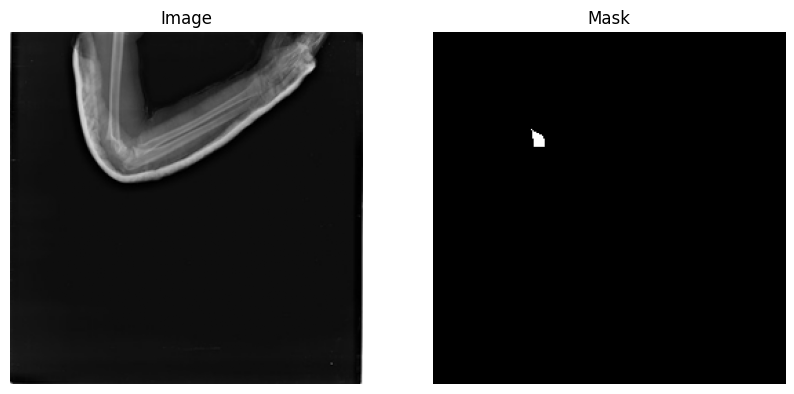

Mask sum: 81.0
load_image_mask received image_id: 645, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 192, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 674, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 639, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 274, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 283, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 344, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 635, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 563, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 184, type: <class 'tensorflow.python.framework.ops

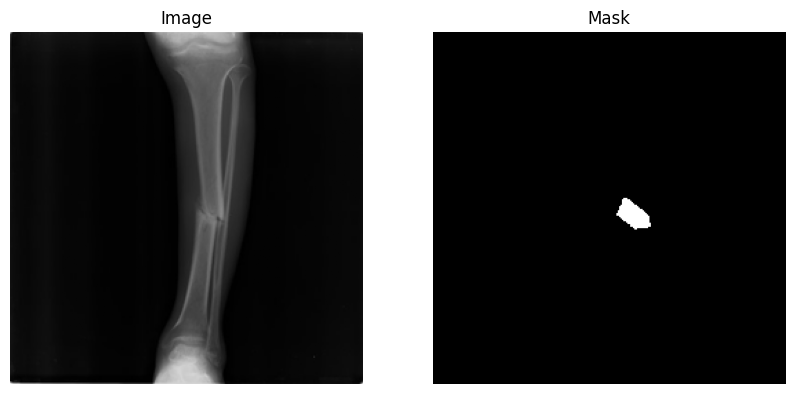

Mask sum: 334.0
load_image_mask received image_id: 359, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 682, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 525, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 711, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 392, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 472, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 503, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 609, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 233, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 271, type: <class 'tensorflow.python.framework.op

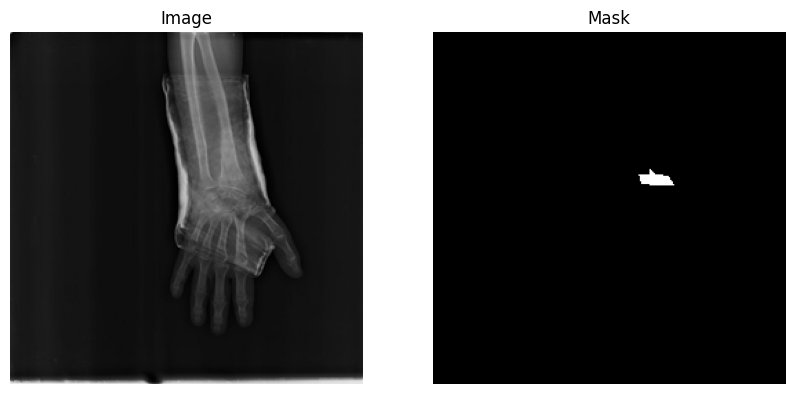

Mask sum: 180.0


In [ ]:
# Debug Cell: Inspect Validation Data
import matplotlib.pyplot as plt

# Take a few samples from the validation dataset
for image, mask in val_dataset.take(3):
    image = image[0]  # Take the first image in the batch
    mask = mask[0]    # Take the first mask in the batch
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image.numpy())
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask.numpy().squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()
    print(f"Mask sum: {tf.reduce_sum(mask).numpy()}")  # Check if the mask has any positive pixels

In [ ]:
# Cell 8: Define CBAM Block
# Purpose: Implement the Convolutional Block Attention Module for enhanced feature extraction.
def channel_attention(inputs, reduction_ratio=8):
    channels = inputs.shape[-1]
    avg_pool = layers.GlobalAveragePooling2D()(inputs)
    avg_pool = layers.Reshape((1, 1, channels))(avg_pool)
    avg_pool = layers.Dense(channels // reduction_ratio, activation='relu')(avg_pool)
    avg_pool = layers.Dense(channels, activation='sigmoid')(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(inputs)
    max_pool = layers.Reshape((1, 1, channels))(max_pool)
    max_pool = layers.Dense(channels // reduction_ratio, activation='relu')(max_pool)
    max_pool = layers.Dense(channels, activation='sigmoid')(max_pool)

    attention = layers.Add()([avg_pool, max_pool])
    attention = layers.Multiply()([inputs, attention])
    return attention

def spatial_attention(inputs, kernel_size=7):
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(inputs)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(inputs)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    conv = layers.Conv2D(1, kernel_size, padding='same', activation='sigmoid')(concat)
    attention = layers.Multiply()([inputs, conv])
    return attention

def cbam_block(inputs, reduction_ratio=8, kernel_size=7):
    channel_att = channel_attention(inputs, reduction_ratio)
    spatial_att = spatial_attention(channel_att, kernel_size)
    return spatial_att

In [ ]:
# Cell 9: Define Convolutional Block for U-Net
# Purpose: Create a reusable convolutional block with CBAM attention for the U-Net architecture.
def conv_block(input_tensor, num_filters, kernel_size=3, activation='relu', use_cbam=True):
    x = layers.Conv2D(num_filters, kernel_size, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(num_filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    if use_cbam:
        x = cbam_block(x)
    return x

In [ ]:
# Cell 10: Build the Model (Updated with Dropout and L2 Regularization)
# Purpose: Define the U-Net model with CBAM blocks.
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Dense, GlobalAveragePooling2D, Reshape, multiply, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# CBAM Block
def cbam_block(cbam_feature, ratio=8):
    # Channel Attention
    cbam_feature = tf.keras.layers.Activation('linear')(cbam_feature)
    channel = cbam_feature.shape[-1]
    shared_layer_one = Dense(channel // ratio, activation='relu', use_bias=True)
    shared_layer_two = Dense(channel, use_bias=True)

    avg_pool = GlobalAveragePooling2D()(cbam_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=[1, 2], keepdims=True))(cbam_feature)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature_channel = tf.keras.layers.Add()([avg_pool, max_pool])
    cbam_feature_channel = Activation('sigmoid')(cbam_feature_channel)

    cbam_feature = multiply([cbam_feature, cbam_feature_channel])

    # Spatial Attention
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(cbam_feature)
    concat = concatenate([avg_pool, max_pool], axis=-1)
    cbam_feature_spatial = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    cbam_feature = multiply([cbam_feature, cbam_feature_spatial])

    return cbam_feature

# Convolution Block with CBAM
def conv_block(inputs, filters, kernel_size=3, use_cbam=True, dropout_rate=0.3):
    conv = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    if use_cbam:
        conv = cbam_block(conv)
    conv = Dropout(dropout_rate)(conv)  # Add dropout
    return conv

# U-Net Model
def unet_with_cbam(input_shape=(256, 256, 3), use_cbam=True):
    inputs = Input(input_shape, name='input_layer_2')

    # Encoder
    c1 = conv_block(inputs, 64, use_cbam=use_cbam)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 128, use_cbam=use_cbam)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 256, use_cbam=use_cbam)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = conv_block(p3, 512, use_cbam=use_cbam)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    b = conv_block(p4, 1024, use_cbam=use_cbam)

    # Decoder
    u4 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(b)
    u4 = concatenate([u4, c4])
    c5 = conv_block(u4, 512, use_cbam=use_cbam)

    u3 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u3 = concatenate([u3, c3])
    c6 = conv_block(u3, 256, use_cbam=use_cbam)

    u2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u2 = concatenate([u2, c2])
    c7 = conv_block(u2, 128, use_cbam=use_cbam)

    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u1 = concatenate([u1, c1])
    c8 = conv_block(u1, 64, use_cbam=use_cbam)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build and summarize the model
model = unet_with_cbam()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ activation_2[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 1, 64)  │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 8)   │        520 │ reshape[0][0],    │
│                     │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 64)  │        576 │ dense[0][0],      │
│                     │                   │            │ dense[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 64)  │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1, 1, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 256,  │          0 │ activation_2[0][… │
│                     │ 64)               │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256, 256,  │          0 │ multiply[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 31,495,724 (120.15 MB)

 Trainable params: 31,483,948 (120.10 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
# Cell 11: Compile and Retrain the Model with Weighted Loss
# Purpose: Define Combined Dice + Weighted BCE Loss, compile the model, and retrain it.
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.backend as K

# Define Dice Coefficient
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Define Combined Dice + Weighted BCE Loss
def dice_weighted_bce_loss(y_true, y_pred, pos_weight=50.0):
    # Dice loss
    dice = 1.0 - dice_coef(y_true, y_pred)

    # Weighted Binary Cross-Entropy
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    bce = K.binary_crossentropy(y_true, y_pred)
    weights = y_true * (pos_weight - 1) + 1  # pos_weight for 1s, 1 for 0s
    weighted_bce = weights * bce
    weighted_bce = K.mean(weighted_bce)

    # Combine Dice and Weighted BCE
    return dice + weighted_bce

# Compile the model with the new loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=lambda y_true, y_pred: dice_weighted_bce_loss(y_true, y_pred, pos_weight=50.0),
    metrics=[dice_coef, 'accuracy']
)

# Define callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_dice_coef',  # Monitor Dice coefficient
        mode='max',               # Maximize Dice coefficient
        patience=12,              # Increase patience to allow more epochs
        restore_best_weights=True
    ),
    callbacks.ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_dice_coef',
        mode='max',
        save_best_only=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_dice_coef',
        mode='max',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

# Retrain the model for 10 more epochs, starting from epoch 13
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=23,  # 13 + 10 more epochs
    initial_epoch=13,  # Start from epoch 13
    callbacks=callbacks_list
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_2']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


Streaming output truncated to the last 5000 lines.
load_image_mask received image_id: 528, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 691, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 9, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9885 - dice_coef: 0.0089 - loss: 1.7158load_image_mask received image_id: 348, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 252, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 585, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 352, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 187, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 124, type: <class 'tensor

load_image_mask received image_id: 605, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 72, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 554, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 424, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 464, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 460, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 231, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 346, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 493, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 505, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
l

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_2']
Received: inputs=Tensor(shape=(16, 256, 256, 3))
  warnings.warn(msg)


load_image_mask received image_id: 387, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 640, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 96, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 541, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 242, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 669, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 577, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 647, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 144, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 414, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
l

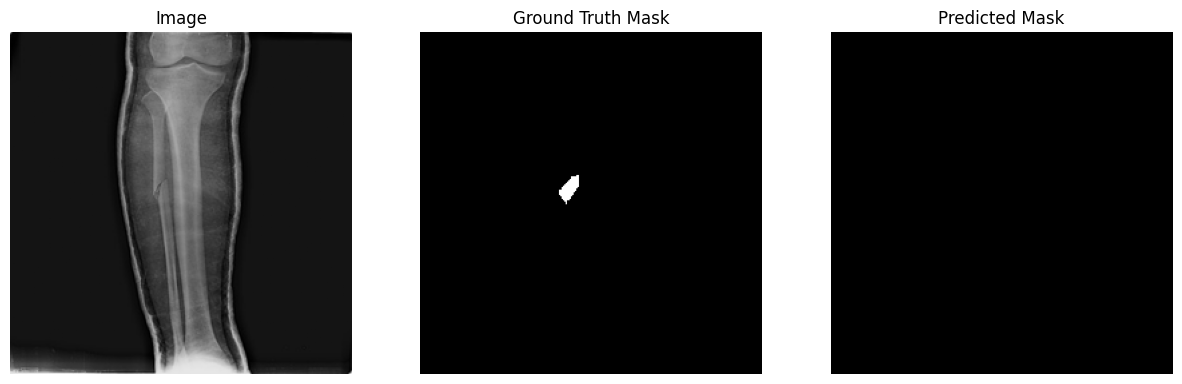

load_image_mask received image_id: 377, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 338, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 33, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 706, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 545, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/stepload_image_mask received image_id: 455, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 467, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
load_image_mask received image_id: 654, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received image_id: 244, type: <class 'tensorflow.python.framework.ops.EagerTensor'>
load_image_mask received

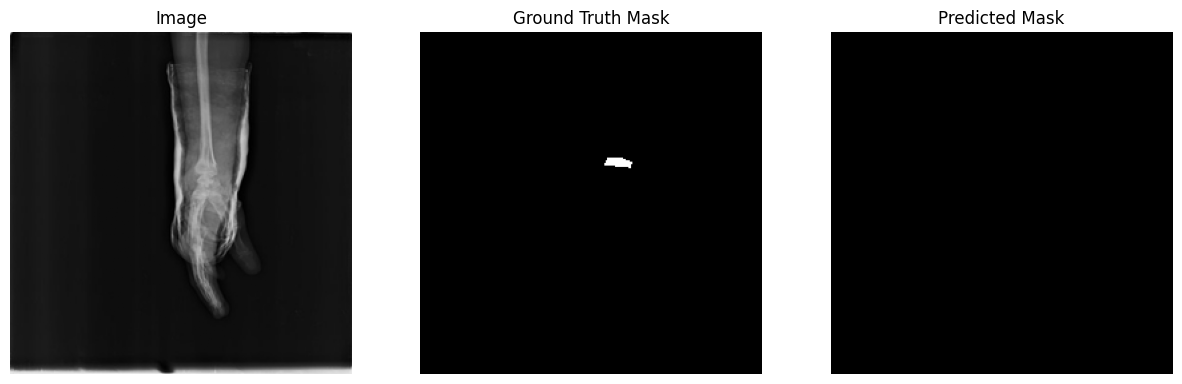

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


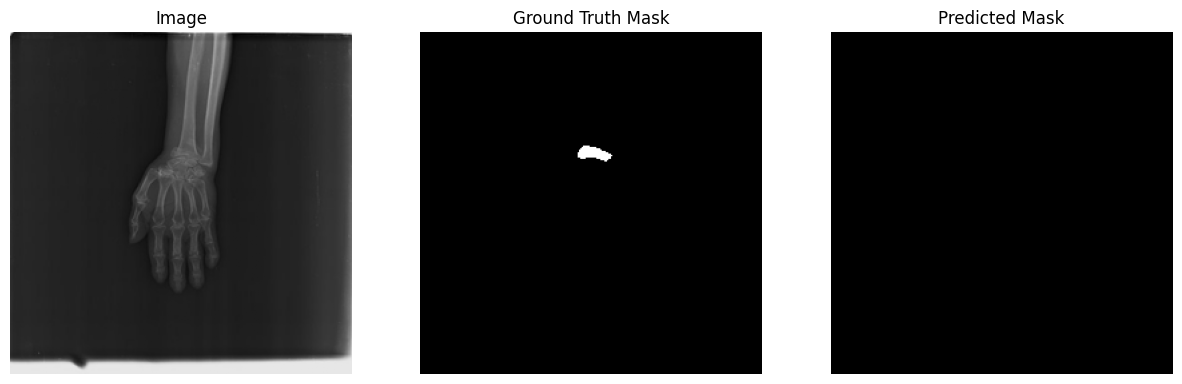

In [ ]:
# Cell 12: Evaluate the Model on Test Set and Visualize Predictions
# Purpose: Evaluate the model on the test set and visualize predictions.

# Wrap the input tensor in a dictionary to match the model's expected input structure
def wrap_input(image, mask):
    return {'input_layer_2': image}, mask

# Apply the wrapping to the test dataset
test_dataset_wrapped = test_dataset.map(wrap_input)

# Evaluate the model on the test dataset
test_loss, test_dice, test_accuracy = model.evaluate(test_dataset_wrapped)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualize predictions on a few test samples
import matplotlib.pyplot as plt
import numpy as np

# Take a few samples from the test dataset
for image, mask in test_dataset.take(3):
    # Wrap the image tensor in a dictionary for prediction
    image_dict = {'input_layer_2': image}
    pred_mask = model.predict(image_dict)

    # Plot the image, ground truth mask, and predicted mask
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image[0].numpy())
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask[0].numpy().squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask[0].squeeze(), cmap='gray')  # No thresholding yet
    plt.axis('off')

    plt.show()
    print(f"Predicted mask sum: {np.sum(pred_mask[0]):.4f}")  # Sum of predicted mask values

In [ ]:
# Debug Cell: Inspect Validation Data
import matplotlib.pyplot as plt
import tensorflow as tf

for image, mask in val_dataset.take(3):
    image = image[0]
    mask = mask[0]
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image.numpy())
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask.numpy().squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()
    print(f"Mask sum: {tf.reduce_sum(mask).numpy()}")

In [ ]:
import numpy as np
import cv2

def preprocess_data(images, masks, img_size=(256, 256)):
    processed_images = []
    processed_masks = []

    for img, mask in zip(images, masks):
        # Ensure mask is binary (0 or 1)
        mask = (mask > 0).astype(np.uint8)

        # Find bounding box of the mask
        coords = cv2.findNonZero(mask)
        if coords is None:
            # If no mask, use the whole image
            x, y, w, h = 0, 0, img_size[0], img_size[1]
        else:
            x, y, w, h = cv2.boundingRect(coords)
            # Add padding (50% of the bounding box size)
            pad_x = int(w * 0.5)
            pad_y = int(h * 0.5)
            x = max(0, x - pad_x)
            y = max(0, y - pad_y)
            w = min(img_size[0] - x, w + 2 * pad_x)
            h = min(img_size[1] - y, h + 2 * pad_y)

        # Crop image and mask
        cropped_img = img[y:y+h, x:x+w]
        cropped_mask = mask[y:y+h, x:x+w]

        # Resize back to original size
        cropped_img = cv2.resize(cropped_img, img_size, interpolation=cv2.INTER_LINEAR)
        cropped_mask = cv2.resize(cropped_mask, img_size, interpolation=cv2.INTER_NEAREST)

        # Normalize
        cropped_img = cropped_img / 255.0
        cropped_mask = (cropped_mask > 0).astype(np.float32)

        processed_images.append(cropped_img)
        processed_masks.append(cropped_mask)

    # Add channel dimension
    processed_images = np.expand_dims(processed_images, axis=-1)
    processed_masks = np.expand_dims(processed_masks, axis=-1)

    return np.array(processed_images), np.array(processed_masks)

# Example usage (replace images, masks with your data)
# images, masks = preprocess_data(images, masks)